# Jo(h)ns of the U.S. Senate
This visualization was inspired by this tweet:

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">When Fetterman takes office in January, 10% of all U.S. senators will be named John/Jon</p>&mdash; Grace Segers (@Grace_Segers) <a href="https://twitter.com/Grace_Segers/status/1590432772812079104?ref_src=twsrc%5Etfw">November 9, 2022</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

I wanted to find out who the current Jo(h)ns are, who they represent, and some other information about them. To do this, I pulled data from the wikipedia page on current US senators:
* Source: https://en.wikipedia.org/wiki/List_of_current_United_States_senators

If you're curious, there's also a notebook running this same analysis on the House of Representatives in the same folder.

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
import datetime as dt

import seaborn as sns

In [2]:
# Senator URL and HTML attribute properties
table_data = {
    'url': "https://en.wikipedia.org/wiki/List_of_current_United_States_senators",
    'attrs': {'class':"wikitable",
              'id': 'senators'}
}

In [3]:
# Get the response in the form of html
wikiurl=table_data['url']
table_class="wikitable sortable jquery-tablesorter"
response=requests.get(wikiurl)
print(response.status_code)

200


In [4]:
# Parse data from the html into a beautifulsoup object
soup = BeautifulSoup(response.text, 'html.parser')
rep_tbl=soup.find('table', table_data['attrs'])

In [5]:
df=pd.read_html(str(rep_tbl))
# convert list to dataframe
df=pd.DataFrame(df[0])

Lets take a look at what this data looks like...

In [6]:
df.head(5)

,State,Portrait,Senator,Party,Party.1,Born,Occupation(s),Previous electiveoffice(s),Education,Assumed office,Class,Residence[2]
0,Alabama,NaN,Richard Shelby,NaN,Republican[d],(age 88),Lawyer,U.S. HouseAlabama Senate,"University of Alabama (BA, LLB) Birmingham Sch...","January 3, 1987",2022Class 3,Tuscaloosa
1,Alabama,NaN,Tommy Tuberville,NaN,Republican,(age 68),College football coachInvestment management fi...,None,Southern Arkansas University (BS),"January 3, 2021",2026Class 2,Auburn[3]
2,Alaska,NaN,Lisa Murkowski,NaN,Republican,(age 65),Lawyer,Alaska House of Representatives,Georgetown University (AB) Willamette Universi...,"December 20, 2002[e]",2022Class 3,Girdwood
3,Alaska,NaN,Dan Sullivan,NaN,Republican,(age 58),U.S. Marine Corps officerLawyerAssistant Secre...,Alaska Attorney General,Harvard University (AB) Georgetown University ...,"January 3, 2015",2026Class 2,Anchorage
4,Arizona,NaN,Kyrsten Sinema,NaN,Democratic,(age 46),Social workerPolitical activistLawyerCollege l...,U.S. HouseArizona SenateArizona House of Repre...,Brigham Young University (BA) Arizona State Un...,"January 3, 2019",2024Class 1,Phoenix


Clearly need to do some work and format some columns

In [7]:
# Drop seemingly empty columns
df_processed = df[['State', 'Senator', 'Party.1', 'Assumed office', 'Born']] \
                 .rename(columns={'Party.1': 'Party'}) \
                 .replace({r'\[[a-zA-Z]+\]':'',
                           r'\(DFL\)': ''}, 
                          regex=True)
df_processed['Assumed office'] = pd.to_datetime(df_processed['Assumed office'],
                                                format='%B %d, %Y',
                                                errors='ignore')
df_processed.head(3)

,State,Senator,Party,Assumed office,Born
0,Alabama,Richard Shelby,Republican,1987-01-03,(age 88)
1,Alabama,Tommy Tuberville,Republican,2021-01-03,(age 68)
2,Alaska,Lisa Murkowski,Republican,2002-12-20,(age 65)


Just for fun let's break down how long senators have been serving by number of years

In [8]:
# Get their age
df_processed['age'] = df_processed.Born.map(lambda x: int(re.search(r'\(age\s([0-9]{2})\)', x).group(1)))
df_processed = df_processed.drop(columns='Born')

In [9]:
# Compute delta-years
df_processed['Years in Office'] = (dt.datetime.now() - df_processed['Assumed office']).dt.days / 365.2425
df_processed.sort_values('Years in Office', ascending=False)

,State,Senator,Party,Assumed office,age,Years in Office
88,Vermont,Patrick Leahy,Democratic,1975-01-03,82,47.858614
28,Iowa,Chuck Grassley,Republican,1981-01-03,89,41.857122
32,Kentucky,Mitch McConnell,Republican,1985-01-03,80,37.857040
0,Alabama,Richard Shelby,Republican,1987-01-03,88,35.858368
8,California,Dianne Feinstein,Democratic,1992-11-10,89,30.004723
...,...,...,...,...,...,...
1,Alabama,Tommy Tuberville,Republican,2021-01-03,68,1.856301
31,Kansas,Roger Marshall,Republican,2021-01-03,62,1.856301
9,California,Alex Padilla,Democratic,2021-01-20,49,1.809757
19,Georgia,Raphael Warnock,Democratic,2021-01-20,53,1.809757


[Text(0.5, 1.0, 'Senators by Years in Office')]

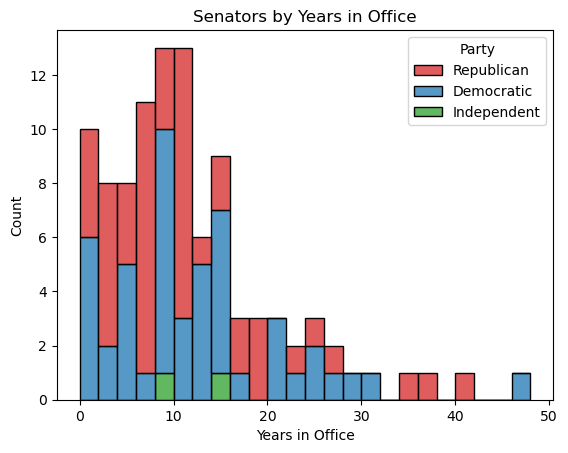

In [10]:
# Plot it up!
sns.histplot(data=df_processed, 
             x="Years in Office", 
             hue='Party',
            #  kde=True,
             multiple='stack',
             bins = range(0,50,2),
             palette={
                'Republican': 'tab:red',
                'Democratic': 'tab:blue',
                'Independent': 'tab:green'
             }) \
   .set(title='Senators by Years in Office')

In [11]:
# 5 longest serving senators:
df_processed.sort_values('Years in Office', ascending=False).iloc[:5]

,State,Senator,Party,Assumed office,age,Years in Office
88,Vermont,Patrick Leahy,Democratic,1975-01-03,82,47.858614
28,Iowa,Chuck Grassley,Republican,1981-01-03,89,41.857122
32,Kentucky,Mitch McConnell,Republican,1985-01-03,80,37.857040
0,Alabama,Richard Shelby,Republican,1987-01-03,88,35.858368
8,California,Dianne Feinstein,Democratic,1992-11-10,89,30.004723


OK, let's do what we came here to do

In [12]:
match_str = r'(Jon|John)'
df_processed['is match'] = df_processed.Senator.map(lambda x: re.match(match_str, x) is not None)
df_processed[df_processed['is match']]

,State,Senator,Party,Assumed office,age,Years in Office,is match
6,Arkansas,John Boozman,Republican,2011-01-03,71,11.857875,True
11,Colorado,John Hickenlooper,Democratic,2021-01-03,70,1.856301,True
18,Georgia,Jon Ossoff,Democratic,2021-01-20,35,1.809757,True
29,Iowa,Joni Ernst,Republican,2015-01-03,52,7.857793,True
35,Louisiana,John Kennedy,Republican,2017-01-03,70,5.856383,True
50,Montana,Jon Tester,Democratic,2007-01-03,66,15.857957,True
66,North Dakota,John Hoeven,Republican,2011-01-03,65,11.857875,True
80,South Dakota,John Thune,Republican,2005-01-03,61,17.856629,True
84,Texas,John Cornyn,Republican,2002-12-02,70,19.945653,True
98,Wyoming,John Barrasso,Republican,2007-06-25,70,15.384299,True


[Text(0.5, 1.0, 'Johns in the Senate by Years in Office')]

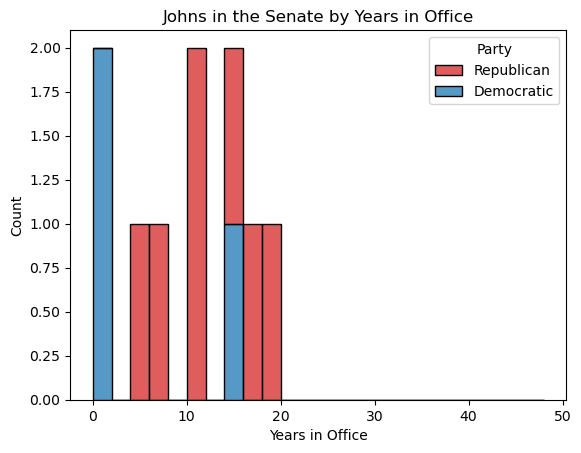

In [13]:
sns.histplot(data=df_processed[df_processed['is match']], 
             x="Years in Office", 
             hue='Party',
            #  kde=True,
             multiple='stack',
             bins = range(0,50,2),
             palette={
                'Republican': 'tab:red',
                'Democratic': 'tab:blue',
                'Independent': 'tab:green'
             }) \
   .set(title='Johns in the Senate by Years in Office')

[Text(0.5, 1.0, 'Johns in the Senate by Age')]

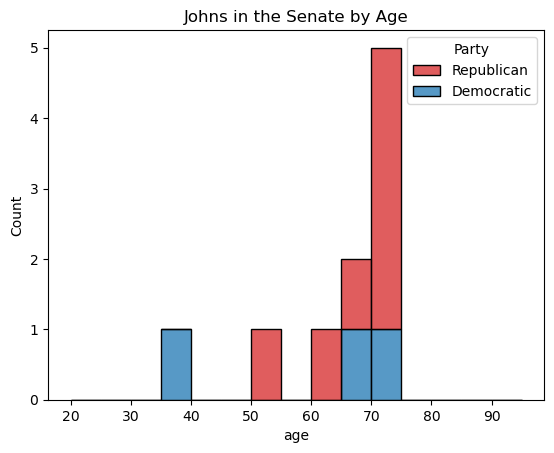

In [14]:
# How old are the Jo(h)n(i)s?
sns.histplot(data=df_processed[df_processed['is match']], 
             x="age", 
             hue='Party',
            #  kde=True,
             multiple='stack',
             bins = range(20,100,5),
             palette={
                'Republican': 'tab:red',
                'Democratic': 'tab:blue',
                'Independent': 'tab:green'
             }) \
   .set(title='Johns in the Senate by Age')

In [15]:
# Join the postal abbreviation to the actual state names
postal = pd.read_csv('../../data/state_abbrv.csv', usecols=[0,1])
df_processed = df_processed.merge(postal, left_on='State', right_on='US STATE')

In [16]:
df_processed

,State,Senator,Party,Assumed office,age,Years in Office,is match,US STATE,POSTAL ABBREVIATION
0,Alabama,Richard Shelby,Republican,1987-01-03,88,35.858368,False,Alabama,AL
1,Alabama,Tommy Tuberville,Republican,2021-01-03,68,1.856301,False,Alabama,AL
2,Alaska,Lisa Murkowski,Republican,2002-12-20,65,19.896370,False,Alaska,AK
3,Alaska,Dan Sullivan,Republican,2015-01-03,58,7.857793,False,Alaska,AK
4,Arizona,Kyrsten Sinema,Democratic,2019-01-03,46,3.857711,False,Arizona,AZ
...,...,...,...,...,...,...,...,...,...
95,West Virginia,Shelley Moore Capito,Republican,2015-01-03,68,7.857793,False,West Virginia,WV
96,Wisconsin,Ron Johnson,Republican,2011-01-03,67,11.857875,False,Wisconsin,WI
97,Wisconsin,Tammy Baldwin,Democratic,2013-01-03,60,9.856465,False,Wisconsin,WI
98,Wyoming,John Barrasso,Republican,2007-06-25,70,15.384299,True,Wyoming,WY


In [17]:
# Import the pandas library
import pandas as pd
import matplotlib.pyplot as plt

plt_data = df_processed[df_processed['is match']]

# Build the choropleth
import plotly.express as px
fig = px.choropleth(plt_data, 
    # geojson=counties, 
    locations=plt_data['POSTAL ABBREVIATION'], 
    locationmode='USA-states',
    color='is match',
    # color_continuous_scale="Viridis",
    # range_color=(0, 12),
    scope="usa",
    labels={'is match':'Has a Jo(h)n'},
    title='Jo(h)ns in the U.S. Senate'
)
fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})

fig.show()